# Classification on a subset of the Food 101 dataset

In [134]:
import os
from pathlib import Path
IMAGE_DIR = Path('./archive/images')

## Load dataset

Only load 3 chosen classes, we do not want to classify all 101 classes.

In [135]:
selected_classes = ["macarons", "french_fries", "hot_dog"]

filepaths = []
for category in selected_classes:
    category_path = IMAGE_DIR / category
    filepaths.extend(list(category_path.glob("*.jpg")))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


### Convert to dataframe

In [136]:
import pandas as pd

filepaths = pd.Series(filepaths, name='path').astype(str)
labels = pd.Series(labels, name='label')
images = pd.concat([filepaths, labels], axis=1)

print(f"Size of dataset: {labels.size}")
images.head()

Size of dataset: 3000


,path,label
0,archive\images\macarons\1001193.jpg,macarons
1,archive\images\macarons\1001527.jpg,macarons
2,archive\images\macarons\1003207.jpg,macarons
3,archive\images\macarons\1003224.jpg,macarons
4,archive\images\macarons\1004903.jpg,macarons


In [137]:
images['label'].value_counts()

label
macarons        1000
french_fries    1000
hot_dog         1000
Name: count, dtype: int64

## Split to train and test sets

In [138]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, train_size=0.8, shuffle=True, random_state=42)
train.size, test.size

(4800, 1200)

## Preprocess images

In [139]:
import tensorflow as tf
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [140]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1920 validated image filenames belonging to 3 classes.
Found 480 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


## Load pre-trained model (MobileNetV2)

In [141]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [142]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(32, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(len(selected_classes), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

## Compile model

In [143]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit model

In [144]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
60/60 [==============================] - 42s 582ms/step - loss: 0.2790 - accuracy: 0.9109 - val_loss: 0.1219 - val_accuracy: 0.9646
Epoch 2/25
60/60 [==============================] - 32s 534ms/step - loss: 0.0794 - accuracy: 0.9703 - val_loss: 0.1104 - val_accuracy: 0.9646
Epoch 3/25
60/60 [==============================] - 33s 549ms/step - loss: 0.0423 - accuracy: 0.9880 - val_loss: 0.1318 - val_accuracy: 0.9542
Epoch 4/25
60/60 [==============================] - 33s 541ms/step - loss: 0.0275 - accuracy: 0.9937 - val_loss: 0.1262 - val_accuracy: 0.9563
Epoch 5/25
60/60 [==============================] - 34s 558ms/step - loss: 0.0145 - accuracy: 0.9974 - val_loss: 0.1269 - val_accuracy: 0.9604


## Evaluate model

In [145]:
loss, accuracy = model.evaluate(test_images, verbose=1)
print(f"Test loss: {loss:.2f}")
print("Test accuracy: {:.2f}%".format(accuracy * 100))

19/19 [==============================] - 9s 456ms/step - loss: 0.1101 - accuracy: 0.9600
Test loss: 0.11
Test accuracy: 96.00%


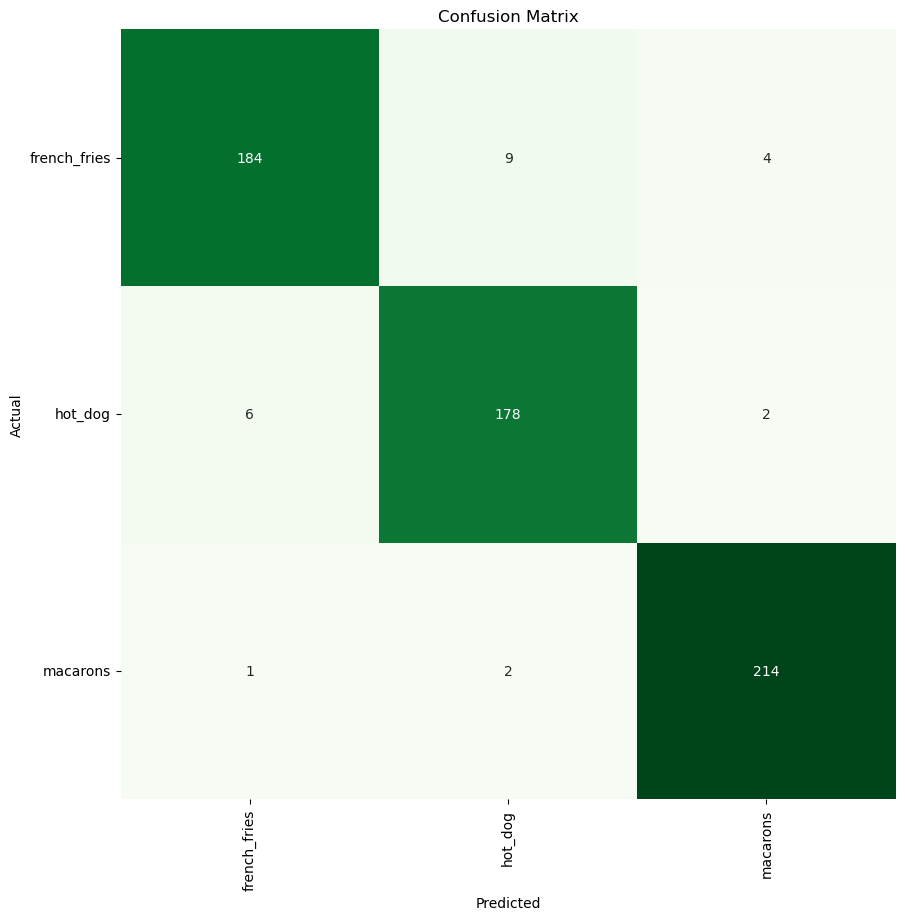

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [147]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

french_fries       0.96      0.93      0.95       197
     hot_dog       0.94      0.96      0.95       186
    macarons       0.97      0.99      0.98       217

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



## Load pre-trained model (EfficentNetB0)

In [152]:
pretrained_model_en = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_en.trainable = False

In [153]:
inputs = pretrained_model_en.input
x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model_en.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)

outputs = tf.keras.layers.Dense(len(selected_classes), activation='softmax')(x)

model_en = tf.keras.Model(inputs, outputs)


print(model_en.summary())

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 224, 224, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
normalization_11 (Normalization (None, 224, 224, 3)  7           rescaling_11[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_11[0][0]           
___________________________________________________________________________________________

## Compile model

In [154]:
model_en.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit model

In [155]:
history_en = model_en.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
60/60 [==============================] - 101s 2s/step - loss: 1.1077 - accuracy: 0.3115 - val_loss: 1.0983 - val_accuracy: 0.3542
Epoch 2/25
60/60 [==============================] - 62s 1s/step - loss: 1.1009 - accuracy: 0.3406 - val_loss: 1.1004 - val_accuracy: 0.3271
Epoch 3/25
60/60 [==============================] - 56s 938ms/step - loss: 1.0997 - accuracy: 0.3318 - val_loss: 1.0991 - val_accuracy: 0.3187
Epoch 4/25
60/60 [==============================] - 58s 967ms/step - loss: 1.0996 - accuracy: 0.3344 - val_loss: 1.0998 - val_accuracy: 0.3271


## Evaluate model

In [156]:
loss, accuracy = model_en.evaluate(test_images, verbose=1)
print(f"Test loss: {loss:.2f}")
print("Test accuracy: {:.2f}%".format(accuracy * 100))

19/19 [==============================] - 14s 728ms/step - loss: 1.1038 - accuracy: 0.3100
Test loss: 1.10
Test accuracy: 31.00%


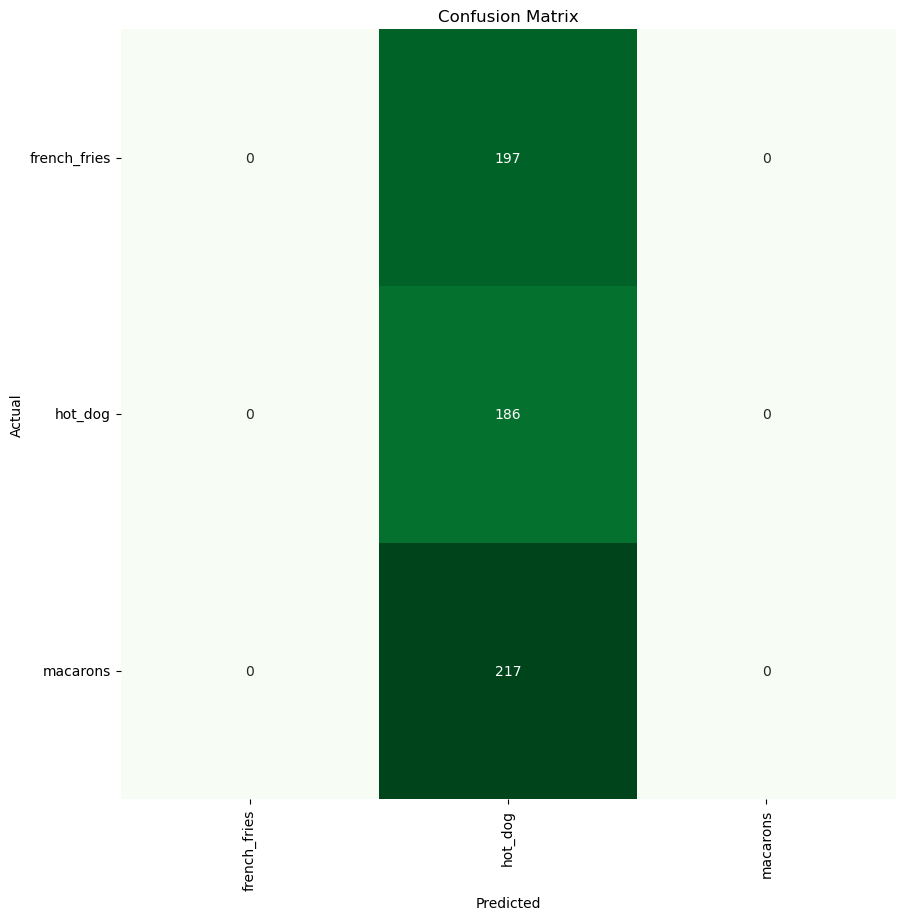

In [157]:
predictions = np.argmax(model_en.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [158]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

french_fries       0.00      0.00      0.00       197
     hot_dog       0.31      1.00      0.47       186
    macarons       0.00      0.00      0.00       217

    accuracy                           0.31       600
   macro avg       0.10      0.33      0.16       600
weighted avg       0.10      0.31      0.15       600



## Load pre-trained model (ResNet50)

In [159]:
pretrained_model_rn = tf.keras.applications.ResNet50(
    include_top=True, 
    weights='imagenet',
    input_shape=(224, 224, 3), 
    pooling='avg'
)

pretrained_model_rn.trainable = False

In [160]:
inputs = pretrained_model_rn.input

x = tf.keras.layers.Dense(32, activation='relu')(pretrained_model_rn.output)
x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(len(selected_classes), activation='softmax')(x)

model_rn = tf.keras.Model(inputs, outputs)


print(model_rn.summary())

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [161]:
model_rn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [162]:
history_rn = model_rn.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
60/60 [==============================] - 124s 2s/step - loss: 1.0987 - accuracy: 0.3391 - val_loss: 1.0977 - val_accuracy: 0.3771
Epoch 2/25
60/60 [==============================] - 122s 2s/step - loss: 1.0975 - accuracy: 0.3500 - val_loss: 1.0959 - val_accuracy: 0.3771
Epoch 3/25
60/60 [==============================] - 123s 2s/step - loss: 1.0939 - accuracy: 0.4115 - val_loss: 1.0894 - val_accuracy: 0.4125
Epoch 4/25
60/60 [==============================] - 128s 2s/step - loss: 1.0865 - accuracy: 0.4198 - val_loss: 1.0783 - val_accuracy: 0.4854
Epoch 5/25
60/60 [==============================] - 128s 2s/step - loss: 1.0726 - accuracy: 0.4516 - val_loss: 1.0610 - val_accuracy: 0.5000
Epoch 6/25
60/60 [==============================] - 125s 2s/step - loss: 1.0566 - accuracy: 0.4703 - val_loss: 1.0452 - val_accuracy: 0.4604
Epoch 7/25
60/60 [==============================] - 127s 2s/step - loss: 1.0404 - accuracy: 0.4677 - val_loss: 1.0355 - val_accuracy: 0.4354
Epoch 8/25
60

In [163]:
loss, accuracy = model_rn.evaluate(test_images, verbose=1)
print(f"Test loss: {loss:.2f}")
print("Test accuracy: {:.2f}%".format(accuracy * 100))

19/19 [==============================] - 75s 4s/step - loss: 0.9160 - accuracy: 0.5583
Test loss: 0.92
Test accuracy: 55.83%


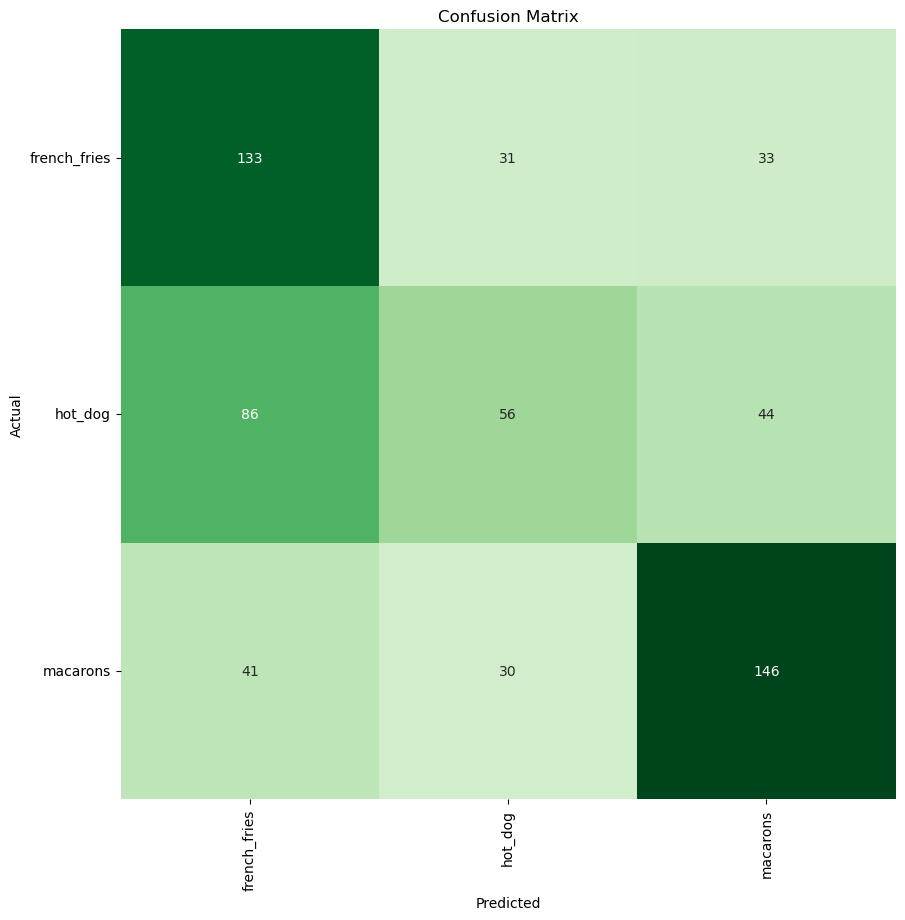

In [164]:
predictions = np.argmax(model_rn.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(len(selected_classes)) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [165]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

french_fries       0.51      0.68      0.58       197
     hot_dog       0.48      0.30      0.37       186
    macarons       0.65      0.67      0.66       217

    accuracy                           0.56       600
   macro avg       0.55      0.55      0.54       600
weighted avg       0.55      0.56      0.55       600

